# Sparkify Project

## Problem Introduction

#### Using the user log data related to a fictitious music streaming service called sparkify, the aim of this project is to train a classification model to predict user churning.

#### Note: All the EDA was done on the mini dataset first. So, in this notebook I haven't added many show or take statements just to reduce the overhead.

### Strategy to solve the problem

- Loading the data
- Removing missing values
- Creating labels (churn or no churn)
- EDA
- Finding relevant features
- Creating features vector
- Training & Comparing classification algorithms (logistic regression, random forest classifier, gradient-boosted tree classifier)
- Choose best model and optimise using K fold cross validation.

### Metrics

- Accuracy : To get an idea that, out of total predicted how many are correctly predicted.
- F1 Score : The class data might be imbalanced, so f1-score could help in such case

### Installing necessary packages

In [4]:
%%configure -f 
{
    "driverMemory": "40G"
}

In [5]:
# emr-5.26.0 or later
sc.install_pypi_package("pandas==0.25.1")
sc.install_pypi_package("matplotlib==3.1.1", "https://pypi.org/simple")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3,application_1632810675398_0004,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Importing necessary packages

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, col, isnan, isnull, udf, datediff, expr, desc, sum, max
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Initialising the spark session 

In [7]:
spark = SparkSession.builder \
    .appName("Sparkify") \
    .getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
spark.conf.set("spark.executor.heartbeatInterval","72000s")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Importing and taking a glance at the data

In [8]:
event_data = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
df = spark.read.json(event_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

## Exploratory Data Analysis (EDA)

### Null values Analysis
 
Counting Null, NAN and empty string values

In [7]:
df.select([count(when(isnan(c),c)).alias(c) for c in df.columns]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+

In [8]:
df.select([count(when(isnull(c),c)).alias(c) for c in df.columns]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+
| artist|auth|firstName|gender|itemInSession|lastName| length|level|location|method|page|registration|sessionId|   song|status| ts|userAgent|userId|
+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+
|5408927|   0|   778479|778479|            0|  778479|5408927|    0|  778479|     0|   0|      778479|        0|5408927|     0|  0|   778479|     0|
+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+

In [9]:
df.select([count(when(col(c)=='',c)).alias(c) for c in df.columns]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+

Based on the null values analysis, we can see that:

1. There are 778479 records without any user information, i.e. userID, first name and gender
2. 5408927 users are doing something other than listening to music, so they don't have any song related information.

Considering the fact that we want to find a pattern in user churning, we can drop the non existing users' data for a while.

In [9]:
df = df.filter(df.firstName.isNotNull())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
df.select('userId').describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|         25480720|
|   mean|1495304.155821578|
| stddev|288531.6714849794|
|    min|          1000025|
|    max|          1999996|
+-------+-----------------+

Average Number of application interactions per user

In [12]:
df.count()/df.select('userId').dropDuplicates().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1143.8129011985457

In [13]:
gender_df = df.groupBy("gender").count().toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

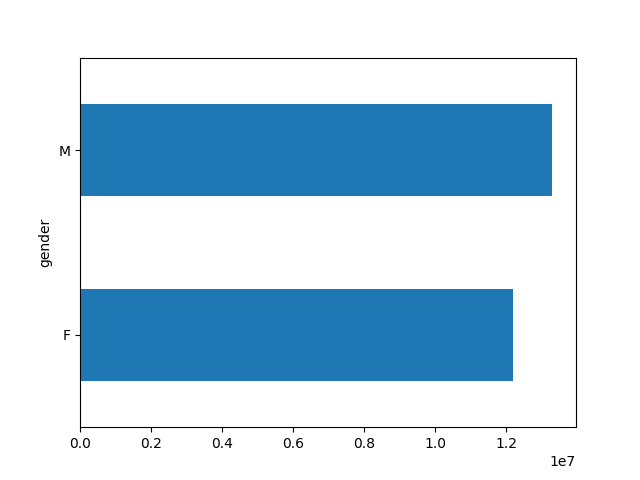

In [14]:
gender_df.plot.barh(x = 'gender',legend = None);
%matplot plt

### Creating churn column

In [10]:
churn_flag = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
df = df.withColumn("churn",churn_flag(df.page))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Analysis based on time spent

In [12]:
reformat_ts = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).strftime("%Y-%m-%d"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
df = df.withColumn("event_time",reformat_ts(df.ts))
df = df.withColumn("registration_time",reformat_ts(df.registration))

df = df.withColumn("TimeSinceRegistration",datediff(df.event_time,df.registration_time))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Let's look for a pattern/trend in between the features and the churning status

#### Time Since Sign up

In [12]:
churn_days_df = df.groupBy("churn").agg(
        expr("avg(TimeSinceRegistration)").alias("Average_Active_Days")
).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

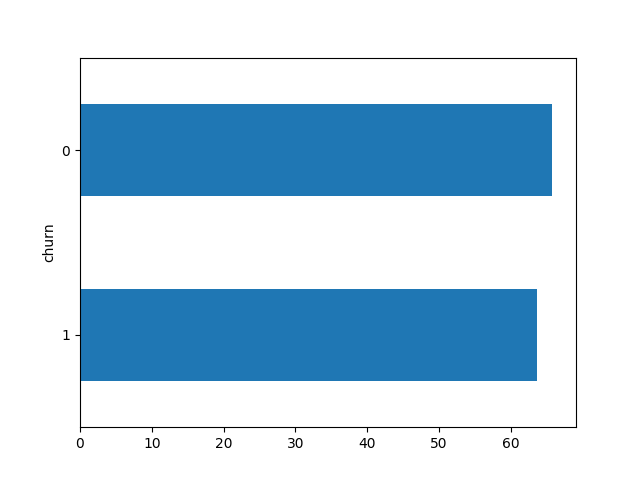

In [20]:
churn_days_df.plot.barh(x = "churn",legend = False);
%matplot plt

Here we can see that the average number of days spent by the users who've churned is more than the time spent by the active users.

##### But this alone doeesn't give us a clear picture as they're VERY close. We can keep it as a DataFrame for future reference.

In [14]:
current_action = df.select('userId','ts').groupby('userId').agg(max(col('ts')).alias('ts')) #to get the latest one
latest_records = current_action.join(df,on='ts').drop(current_action.userId) #as two userId columns were created

active_status_df = latest_records.select("userId","TimeSinceRegistration").dropDuplicates(["UserId"])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's create a dataframe specifically for churn status

In [15]:
churned = df.select('userId', 'churn').groupby('userId') \
            .agg(sum(col('churn')).alias('churned'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's check the number of artists each user listens to

In [16]:
n_artists_df = df.groupBy("userId").agg(
        expr("count(artist)").alias('n_artists')
).sort(col("n_artists").desc())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
n_artists_churn = n_artists_df.join(other=churned,on="userId")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
n_artists_churn_yes = n_artists_churn.select("n_artists").where(n_artists_churn.churned == 1).toPandas()
n_artists_churn_no = n_artists_churn.select("n_artists").where(n_artists_churn.churned == 0).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

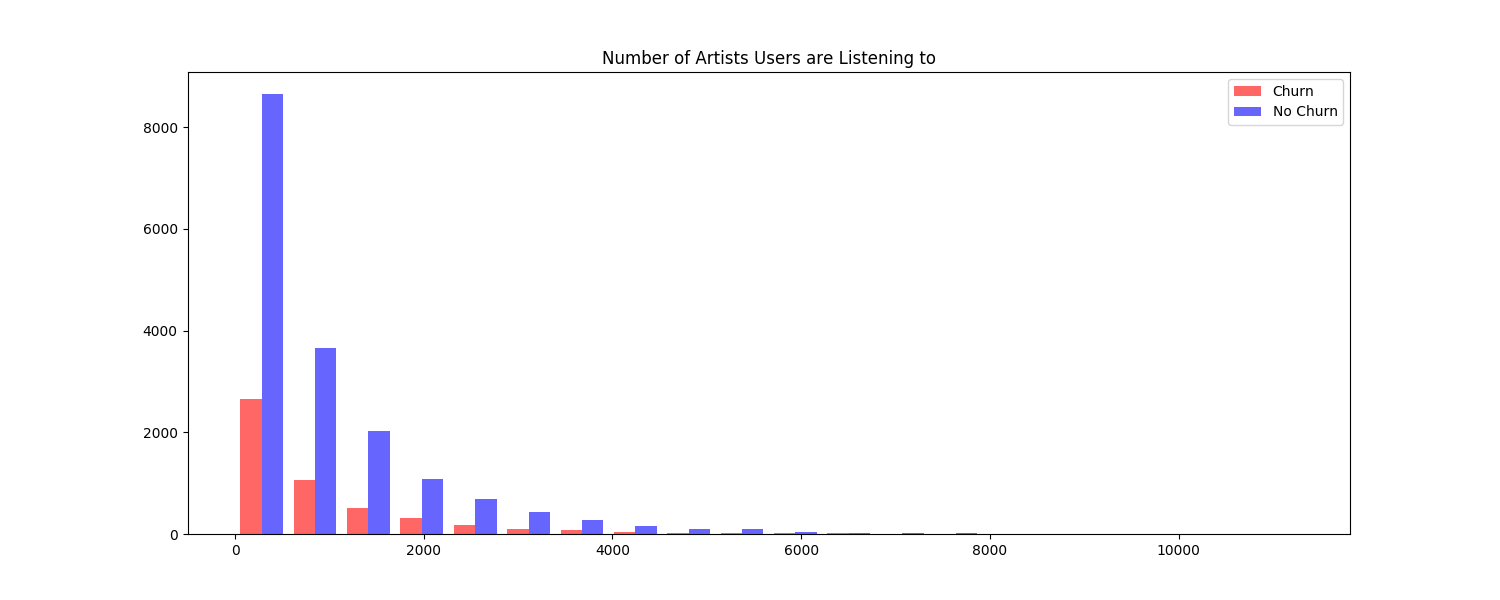

In [26]:
plt.figure(figsize=(15,6))
artists_plot = plt.subplot()
artists_plot.hist([n_artists_churn_yes['n_artists'], n_artists_churn_no['n_artists']], \
                 color=['r','b'], alpha=0.6, bins = 20);
artists_plot.set_title('Number of Artists Users are Listening to');
artists_plot.legend(['Churn', 'No Churn']);
%matplot plt

#### So, users who have listened to large number of artists are less likely to churn

Let's check if the user churns even after giving a good review (thumbs up)

In [18]:
thumbs_df = df.select("userId","page").where(df.page == "Thumbs Up").groupby("userId").agg(count("page").alias("n_Thumbs"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
thumbs_churn = churned.join(other = thumbs_df,on = "userId")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
thumbs_churn_yes = thumbs_churn.select("n_Thumbs").where(col("churned")==1).toPandas()
thumbs_churn_no = thumbs_churn.select("n_Thumbs").where(col("churned")==0).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

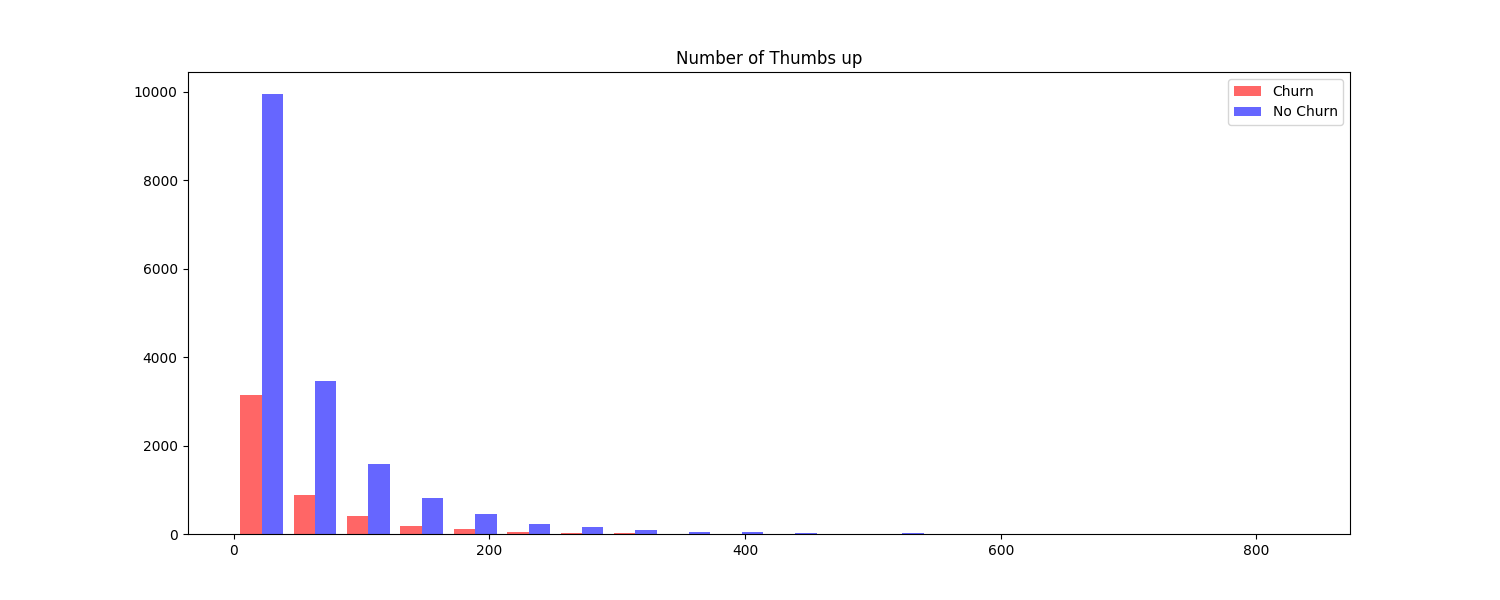

In [30]:
plt.figure(figsize=(15,6))
thumb_plot = plt.subplot()

thumb_plot.hist([thumbs_churn_yes["n_Thumbs"],thumbs_churn_no["n_Thumbs"]],\
               color = ['r','b'], alpha = 0.6, bins = 20)
thumb_plot.set_title('Number of Thumbs up');
thumb_plot.legend(['Churn', 'No Churn']);
%matplot plt

#### So, users who have given more thumbs up are less likely to churn

Let's check what version (Paid or Free) the users are at

In [20]:
account_status = df.select("userId","page","ts")\
                    .where((df.page == 'Submit Upgrade') | (df.page=='Submit Downgrade'))
status = account_status.groupby("userId").agg(max(col("ts")).alias("current"))
current_status = status.join(other=account_status, on = "UserId")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
status_label = udf(lambda x: 1 if x == "Submit Upgrade" else 0,IntegerType())

current_status = current_status.withColumn("status",status_label(current_status.page)).select("userId","status")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Also, if a person adds a song to the playlist, there are very high odds that the person won't churn

In [22]:
add_To_playlist = df.select('userId', 'page').where(col('page') == 'Add to Playlist')
playlist_length = add_To_playlist.groupby('userId').agg(count("page").alias("Songs in Playlist"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Based on the above features, I believe, we can create a good model

## Data Preparation

In [23]:
final_df = churned.join(other = playlist_length,on = "userId")\
            .join(other = current_status,on = "userId")\
            .join(other = thumbs_df,on = "userId")\
            .join(other = active_status_df,on = "userId")\
            .join(other = n_artists_df,on = "userId").dropDuplicates(["userId"])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
final_df = final_df.drop(col("userId"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Vectorisation & Scaling

In [25]:
features = ["Songs in Playlist","status","n_Thumbs","TimeSinceRegistration","n_artists"]
assembler = VectorAssembler(inputCols=features,outputCol="NumFeatures")

final_vector_df = assembler.transform(final_df)
final_vector_df = final_vector_df.withColumnRenamed("churned","label")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
scale = StandardScaler(inputCol="NumFeatures",outputCol="features")
scaler = scale.fit(final_vector_df)
scaled_final_df = scaler.transform(final_vector_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
scaled_final_df = scaled_final_df.select(["label","features"])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Train Test Split

In [29]:
train, test = scaled_final_df.randomSplit([.75,.25],seed=42)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Modelling

#### Creating the models with default hyperparameters

### Logistic Regression

In [40]:
lr_cv = LogisticRegression(featuresCol="features",labelCol="label")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
lr_cv_model = lr_cv.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
lr_results = lr_cv_model.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Random Forest

In [43]:
rfc_cv = RandomForestClassifier(labelCol="label",featuresCol="features")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
rfc_cv_model = rfc_cv.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [45]:
rfc_results = rfc_cv_model.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Gradient Boosted Trees

In [46]:
gbt_cv = GBTClassifier(featuresCol="features", labelCol="label")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [47]:
gbt_cv_model = gbt_cv.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-47:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 1830



In [48]:
gbt_results = gbt_cv_model.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Results

In [30]:
evaluator = MulticlassClassificationEvaluator()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Logistic Regression

In [50]:
print('Accuracy : {}'.format(lr_results.filter(lr_results.label==lr_results.prediction).count() / lr_results.count()))
print('F1 Score :{0:.4f}'.format(evaluator.evaluate(lr_results, {evaluator.metricName:'f1'})))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy : 0.7699530516431925
F1 Score :0.6818

#### Random Forest Classifier

In [51]:
print('Accuracy : {}'.format(rfc_results.filter(rfc_results.label==rfc_results.prediction).count() / rfc_results.count()))
print('F1 Score :{0:.4f}'.format(evaluator.evaluate(rfc_results, {evaluator.metricName:'f1'})))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy : 0.7849765258215963
F1 Score :0.7483

#### Gradient Boosted Trees

In [52]:
print('Accuracy : {}'.format(gbt_results.filter(gbt_results.label==gbt_results.prediction).count() / gbt_results.count()))
print('F1 Score :{0:.4f}'.format(evaluator.evaluate(gbt_results, {evaluator.metricName:'f1'})))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy : 0.7799687010954617
F1 Score :0.7479

## Hyperparameter Tuning

In [31]:
gbt = GBTClassifier(featuresCol="features", labelCol="label")

gbt_param_grid = ParamGridBuilder() \
            .addGrid(gbt.maxIter,[5,10]) \
            .build()

gbt_cv = CrossValidator(estimator=gbt,
                      estimatorParamMaps = gbt_param_grid,
                      evaluator = MulticlassClassificationEvaluator(),
                      numFolds = 3,
                      parallelism=2
                      )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
gbt_cv_model = gbt_cv.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-28:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



In [33]:
gbt_results = gbt_cv_model.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-29:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



In [35]:
print('F1 Score after optimisation:{0:.4f}'.format(evaluator.evaluate(gbt_results, {evaluator.metricName:'f1'})))

VBox()

Exception in thread cell_monitor-31:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

F1 Score after optimisation:0.7405

## Conclusion

The models are able to predict the churn status with a pretty good accuracy. More models can be tested to get a broader idea.

For new data I believe that a tree based model is the best choice. I'll not be going with the optimised model as of now as the f1-score is almost similar but the model itself is taking a lot of time.

## Improvements

- Increase dataset size
- Use different ratios for train/test split
- More parameters could be added to the param_grid for cross validation
- More classification algorithms could be tried